In [2]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('monokai')

# **Loan Default factors analysis**

by: Moiez Ismail

#### Table of Contents:
- [Introduction](#Introduction)
- [Data overview](#Data-overview)
- [Data cleaning](#Data-cleaning)
- [Loan amount and property value analysis](#Loan-amount-and-property-value-analysis)
- [Debt and credit history analysis](#Debt-and-credit-history-analysis)
- [Employment and loan reason analysis](#Employment-and-loan-reason-analysis)
- [Statistical tests and correlation analysis](#statistical-tests-and-correlation-analysis)
- [Insights from EDA](#Insights-from-eda)
- [Conclusion](#Conclusion)

# Introduction
A ficticious bank, Global Bank (GB) derives profit from interest on loans but faces risks when clients default on their loans (DL). Not every loan that is approved is paid off (GL), and the loan approval process is crucial to minimize defaults and maximize good loans. The bank's decision-making on loan approvals, based on various factors, is not infallible and is subject to human error. 
## Objective
- To mitigate this, GB is conducting a data analysis in order to gain insights in order to assist in the loan approval process. 
## Key Questions
- What factors or category of factors are most indicative of a client's likelihood to default? 
- Is there a statistically significant difference in certain numerica/categorical features between clients who default and those who do not?

## Client Profile Analysis
- Analysis of client-related factors such as `JOB`, `YOJ` (Years on Job), and their relationship to loan defaults.
## Financial Indicators Analysis
- Exploration of `DEBTINC` (Debt-to-Income ratio) and its correlation with default rates.
- Analysis of clients' financial health indicators and their predictive power for loan defaults.

## Loan Characteristics Analysis
- Detailed examination of `LOAN`, `MORTDUE` (Mortgage due), and `VALUE` (Property Value) variables.
- Investigating how the size and purpose of the loan (`REASON`) relate to default risks.

## Risk Factors Analysis
- Analysis of credit risk indicators such as `DEROG`, `DELINQ`, and `NINQ` (Number of Inquiries).
- Understanding how past credit performance influences the likelihood of loan defaults.

### Data dictionary
| Variable  | Data Type     | Description                                                                                               |
|-----------|---------------|-----------------------------------------------------------------------------------------------------------|
| BAD       | Binary (1/0)  | 1 = Client defaulted on loan, 0 = loan repaid                                                            |
| LOAN      | Numeric       | Amount of loan approved.                                                                                  |
| MORTDUE   | Numeric       | Amount due on the existing mortgage.                                                                      |
| VALUE     | Numeric       | Current value of the property.                                                                           |
| REASON    | Categorical   | Reason for the loan request. (HomeImp = home improvement, DebtCon = debt consolidation)                   |
| JOB       | Categorical   | The type of job that loan applicant has, such as manager, self, etc.                                      |
| YOJ       | Numeric       | Years at present job.                                                                                    |
| DEROG     | Numeric       | Number of major derogatory reports (indicating serious delinquency or late payments).                     |
| DELINQ    | Numeric       | Number of delinquent credit lines (a line of credit becomes delinquent when payments are overdue).        |
| CLAGE     | Numeric       | Age of the oldest credit line in months.                                                                 |
| NINQ      | Numeric       | Number of recent credit inquiries.                                                                        |
| CLNO      | Numeric       | Number of existing credit lines.                                                                          |
| DEBTINC   | Numeric       | Debt-to-income ratio (monthly debt payments divided by gross monthly income, a measure of repayment ability). |

## **Import the necessary libraries and data**

In [3]:
import plotly.io as pio
pio.renderers.default = "svg"
import pandas as pd
import uuid
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
#statistics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import skew, pearsonr, normaltest, ttest_ind, f_oneway, chisquare, chi2_contingency, shapiro

## Data overview
1. understanding the shape of data, data types and missing values
2. checking for duplicated values
3. having a look at the summary statistics of the numerical columns

In [4]:
data = pd.read_csv('/Users/moiezismail/projects/loan/raw_loan_data.csv')
loan = data.copy() # my working dataframe

In [5]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [6]:
# Code to find out the % of missing values for each column 
np.round(loan.isnull().sum() / len(loan.isnull()) * 100)

BAD         0.0
LOAN        0.0
MORTDUE     9.0
VALUE       2.0
REASON      4.0
JOB         5.0
YOJ         9.0
DEROG      12.0
DELINQ     10.0
CLAGE       5.0
NINQ        9.0
CLNO        4.0
DEBTINC    21.0
dtype: float64

#### Observation
- will make execute decision here to get rid of nulls where % is less than 10%

In [7]:
# Let's a look of a sample of the dataframe
loan.sample(5)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
393,0,6400,28041.0,33438.0,DebtCon,Other,1.0,1.0,0.0,10.425643,10.0,6.0,29.753700
5089,0,27200,61000.0,104044.0,DebtCon,Other,16.0,0.0,1.0,141.981234,0.0,30.0,39.546508
699,0,8100,54841.0,71400.0,DebtCon,Office,6.0,0.0,0.0,89.233333,2.0,15.0,NaN
4104,0,21400,128095.0,167824.0,DebtCon,ProfExe,6.0,0.0,0.0,180.417354,0.0,38.0,17.495700
1030,0,9500,43210.0,59692.0,HomeImp,Other,1.0,1.0,NaN,103.089483,NaN,13.0,38.704985


**Observations**
1. the only variables that don't have missing values are: BAD and LOAN
2. the MORTDUE, YOJ, DEROG, and DEBTINC variables have many missing variables
3. will create drop null values in the REASON category as NULL does not mean = lack of a value. When someone is taking out a loan(there must be some reason but may not fit into home improvement or debt reconciliation but 'other' as a category is not helpful or explanatory 
5. For JOB, I will drop null values since the bank would not approve a loan to unmployed individuals or people who do not have a business etc. but i CANNOT just impute a value such as 'Other' since that is not explanatory

In [8]:
loan.duplicated().sum()

0

No duplicate values

#### Summary statistics

In [9]:
np.round(loan.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
BAD,5960.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
LOAN,5960.0,18607.97,11207.48,1100.00,11100.00,16300.00,23300.00,89900.00
MORTDUE,5442.0,73760.82,44457.61,2063.00,46276.00,65019.00,91488.00,399550.00
VALUE,5848.0,101776.05,57385.78,8000.00,66075.50,89235.50,119824.25,855909.00
YOJ,5445.0,8.92,7.57,0.00,3.00,7.00,13.00,41.00
DEROG,5252.0,0.25,0.85,0.00,0.00,0.00,0.00,10.00
DELINQ,5380.0,0.45,1.13,0.00,0.00,0.00,0.00,15.00
CLAGE,5652.0,179.77,85.81,0.00,115.12,173.47,231.56,1168.23
NINQ,5450.0,1.19,1.73,0.00,0.00,1.00,2.00,17.00
CLNO,5738.0,21.30,10.14,0.00,15.00,20.00,26.00,71.00


**Observations**
1. The target variable, BAD, has an average of 0.20 which means 20% of clients are DL and 80% of GL
2. DEBTINC : the mean and median are the exact same(indicating a normal distribution) so I'll use that to impute the NULLs 
2. The average loan amount approved is 18,607 USD with the highest value approved almost 90,000
3. The range for Mortage due on the house is quite wild since the highest value is almost 400k USD with a standard deviation of 44k USD
4. Years on job avearges at around 9 years with a standard deviation at almost the same amount indicating quite a large range for the interquartile range
5. DEROG, DELINQ, NINQ are small value range so I'll use countplots for visualization
6. CLNO is not a high but not as low as the small range variables so I'll use the mean to impute values

### Data cleaning

In [10]:
# Let's create a categorical variable for the defaulting status of clients
loan['Status'] = loan['BAD'].apply(lambda x: 'Good' if x == 0 else 'Default')

In [11]:
# A dataframe for the averages of all variables against the defaulting status 
np.round(loan.groupby(['Status']).mean(),2).T

Status,Default,Good
BAD,1.00,0.00
LOAN,16922.12,19028.11
MORTDUE,69460.45,74829.25
VALUE,98172.85,102595.92
YOJ,8.03,9.15
DEROG,0.71,0.13
DELINQ,1.23,0.25
CLAGE,150.19,187.00
NINQ,1.78,1.03
CLNO,21.21,21.32


In [12]:
# Having age in months doesnt make sense while other age-related variables are in years
loan['CLAGE'] = loan['CLAGE'] / 12

### Treating Outliers

Outliers will affect the model's performance and this dataset has many so let's deal with them. 

In [13]:
def treat_outliers(df,col):
    '''
    treats outliers in a variable
    df: data frame
    col: name of the column
    '''
    
    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR=Q3 - Q1   # IQR Range
    lower_lim = Q1 - (1.5 * IQR) #define lower limit
    upper_lim = Q3 + (1.5 * IQR)  # define upper limit
    
    df[col] = np.clip(df[col], lower_lim, upper_lim)
    return df
# all the values smaller and larger than the limits will be dropped  

def treat_outliers_all(df, col_list):
    '''
    treat outlier in all numerical varaibles
    col_list: list of numerical variables
    df: data frame
    '''
    for c in col_list:
        df = treat_outliers(df, c)
        
    return df

num_col = ['LOAN','MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
loan = treat_outliers_all(loan, num_col)

In [14]:
loan.sample(3).T

,2277,4950,5863
BAD,0,0,0
LOAN,13900,26100,41600
MORTDUE,155486.0,50605.0,41301.0
VALUE,178789.0,77841.0,67400.0
REASON,DebtCon,DebtCon,DebtCon
JOB,ProfExe,Other,Office
YOJ,7.0,21.0,5.0
DEROG,NaN,NaN,1.0
DELINQ,1.0,0.0,NaN
CLAGE,16.040193,23.870684,15.125196


### Treating Missing Values
#### Imputing Values with KNN Imputer
- the K-Nearest Neighbors (KNN) imputation method is a more nuanced and context-sensitive solution compared to simple median or mean imputation.
#### Categorical Variables (JOB, REASON)
- For records with missing values in these categorical variables, we have chosen to remove them. This underscores the importance of having complete information for loan processing.

In [15]:
from sklearn.impute import KNNImputer
# Drop missing variables in the categorical variables as it's a small portion
loan = loan.dropna(subset=['JOB', 'REASON'])
loan = loan[loan['JOB'] != 'Other']

# Select columns to be imputed
columns_to_impute = ['VALUE', 'MORTDUE', 'YOJ', 'DEBTINC', 
                     'CLNO', 'CLAGE', 'DEROG', 'NINQ', 'DELINQ']

knn_imputer = KNNImputer(n_neighbors=5)

# Impute missing values
loan[columns_to_impute] = knn_imputer.fit_transform(loan[columns_to_impute])


In [16]:
loan.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
Status     0
dtype: int64

In [17]:
# Decimal values for large number features dont need precision
round_col = ['LOAN','MORTDUE','VALUE','YOJ','CLAGE','CLNO']
loan[round_col] = loan[round_col].round()

In [18]:
loan.sample(3).T

,4977,5545,1932
BAD,0,1,0
LOAN,26300,35000,12700
MORTDUE,78851.0,159306.0,58293.0
VALUE,109090.0,200447.0,82594.0
REASON,DebtCon,DebtCon,DebtCon
JOB,Office,ProfExe,Office
YOJ,8.0,4.0,13.0
DEROG,0.0,0.0,0.0
DELINQ,0.0,0.0,0.0
CLAGE,34.0,16.0,9.0


In [19]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 4 to 5934
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3216 non-null   int64  
 1   LOAN     3216 non-null   int64  
 2   MORTDUE  3216 non-null   float64
 3   VALUE    3216 non-null   float64
 4   REASON   3216 non-null   object 
 5   JOB      3216 non-null   object 
 6   YOJ      3216 non-null   float64
 7   DEROG    3216 non-null   float64
 8   DELINQ   3216 non-null   float64
 9   CLAGE    3216 non-null   float64
 10  NINQ     3216 non-null   float64
 11  CLNO     3216 non-null   float64
 12  DEBTINC  3216 non-null   float64
 13  Status   3216 non-null   object 
dtypes: float64(9), int64(2), object(3)
memory usage: 376.9+ KB


In [20]:
loan.describe().T

,count,mean,std,min,25%,50%,75%,max
BAD,3216.0,0.183458,0.387102,0.000000,0.000000,0.000000,0.000000,1.000000
LOAN,3216.0,18736.256219,9367.514638,1700.000000,11900.000000,17200.000000,23800.000000,41600.000000
MORTDUE,3216.0,80290.233209,38168.034519,2619.000000,54055.750000,73986.000000,101414.500000,159306.000000
VALUE,3216.0,110858.118781,46651.889058,12500.000000,75000.000000,101251.000000,139578.500000,200447.000000
YOJ,3216.0,8.529229,6.820636,0.000000,3.000000,7.000000,12.000000,28.000000
DEROG,3216.0,0.224005,0.711266,0.000000,0.000000,0.000000,0.000000,8.000000
DELINQ,3216.0,0.495585,1.150944,0.000000,0.000000,0.000000,0.400000,15.000000
CLAGE,3216.0,15.293221,6.483584,0.000000,10.000000,15.000000,19.000000,34.000000
NINQ,3216.0,1.051306,1.303639,0.000000,0.000000,1.000000,2.000000,5.000000
CLNO,3216.0,22.735697,8.926054,0.000000,17.000000,22.000000,28.000000,42.000000


## Data Cleaning Summary

#### Creation of New Features:
- Added a new categorical variable `Status` derived from the `BAD` column to categorize clients as 'Good' (0) or 'Default' (1).
- Computed averages of all variables against the defaulting status for a clearer overview.

#### Normalization and Rounding:
- Transformed `CLAGE` (Age of oldest credit line) from months to years for consistency with other age-related variables.
- Rounded large numerical values such as `LOAN`, `MORTDUE`, `VALUE`, `YOJ`, `CLAGE`, and `CLNO` for better readability.

#### Outlier Treatment:
- Applied a function to identify and treat outliers in key numerical variables to minimize their impact on the analysis.

#### Handling Missing Values:
- Imputed missing values in numerical variables using the k-NN imputer
- For categorical variables like REASON and JOB rows with missing values in these crucial categories were removed to maintain data integrity.

### Export cleaned data as CSV file

In [34]:
loan.to_csv('cleaned_loan.csv', index=False)

## Analysis

In [21]:
loan.describe().T

,count,mean,std,min,25%,50%,75%,max
BAD,3216.0,0.183458,0.387102,0.000000,0.000000,0.000000,0.000000,1.000000
LOAN,3216.0,18736.256219,9367.514638,1700.000000,11900.000000,17200.000000,23800.000000,41600.000000
MORTDUE,3216.0,80290.233209,38168.034519,2619.000000,54055.750000,73986.000000,101414.500000,159306.000000
VALUE,3216.0,110858.118781,46651.889058,12500.000000,75000.000000,101251.000000,139578.500000,200447.000000
YOJ,3216.0,8.529229,6.820636,0.000000,3.000000,7.000000,12.000000,28.000000
DEROG,3216.0,0.224005,0.711266,0.000000,0.000000,0.000000,0.000000,8.000000
DELINQ,3216.0,0.495585,1.150944,0.000000,0.000000,0.000000,0.400000,15.000000
CLAGE,3216.0,15.293221,6.483584,0.000000,10.000000,15.000000,19.000000,34.000000
NINQ,3216.0,1.051306,1.303639,0.000000,0.000000,1.000000,2.000000,5.000000
CLNO,3216.0,22.735697,8.926054,0.000000,17.000000,22.000000,28.000000,42.000000


#### Observations
1. **Default Rate (BAD)**: The mean is approximately 0.18 with a standard deviation of 0.387.

2. **Loan Amount (LOAN)**: The mean loan amount is $\$18,736$ standard deviation is $\$9,367$ with a range from $\$1,700$ to $\$41,600$.

3. **Mortgage Due (MORTDUE)**: The average mortgage due is $\$80,153$ with a standard deviation of $\$38,088$.

4. **Property Value (VALUE)**: The mean property value stands at $\$111,042$ with a standard deviation of $\$46,337$.

5. **Years at Present Job (YOJ)**: The average number of years at the current job is 8.5 with a standard deviation of 6.8 years.

6. **Derogatory Reports (DEROG)**: The mean number of derogatory reports is 0.19 with a standard deviation of 0.699.

7. **Delinquent Credit Lines (DELINQ)**: The average number of delinquent credit lines is 0.468 with a standard deviation of 1.135.

8. **Age of Oldest Credit Line (CLAGE)**: The mean age of the oldest credit line is 15.31 years, with a standard deviation of 6.46 years.

9. **Recent Credit Inquiries (NINQ)**: There is an average of 1.039 recent credit inquiries per client with a standard deviation of 1.294.

10. **Number of Credit Lines (CLNO)**: The average number of credit lines is 22.76 with a standard deviation of 8.89.

11. **Debt-to-Income Ratio (DEBTINC)**: The average debt-to-income ratio is 33.98% with a standard deviation of 6.40%.


#### Numerical variables analysis
- Let's have an initial look at all of the numerical variables involved to see if
there is any correlation and if so, how strong with the target variable

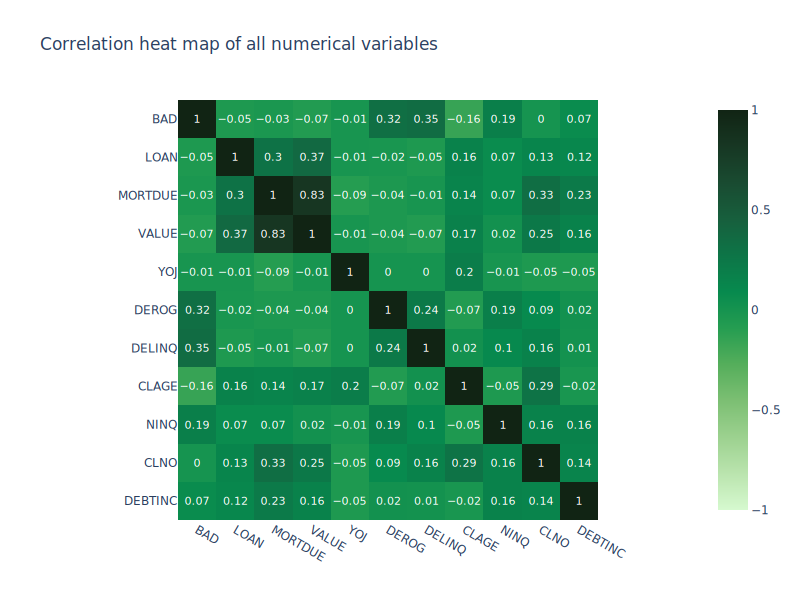

In [27]:

fig = px.imshow(np.round(loan.corr(),2),
                range_color=[-1, 1],
                text_auto=True, title='Correlation heat map of all numerical variables',
                color_continuous_scale='algae')
fig.update_layout(width=800, height=600)
fig.write_image("heatmap.png")
fig.show()

#### Observations
- The default status (BAD) is most strongly correlated with DEROG and DELINQ, highlighting the importance of credit history as a significant factor in assessing default risk.

- all in all, there are no strong correlations between BAD and other financial indicators such as  property value, or years at the job, indicating that no single financial metric is a strong predictor of loan default on its own.

#### 1. What is the range of values for the loan amount variable "LOAN"?

In [38]:
loan.LOAN.min(),loan.LOAN.max()
print(f"The range of the amount of loan is ${loan.LOAN.max() - loan.LOAN.min()}") 

The range of the amount of loan is $39900


#### Multi-distribution 1

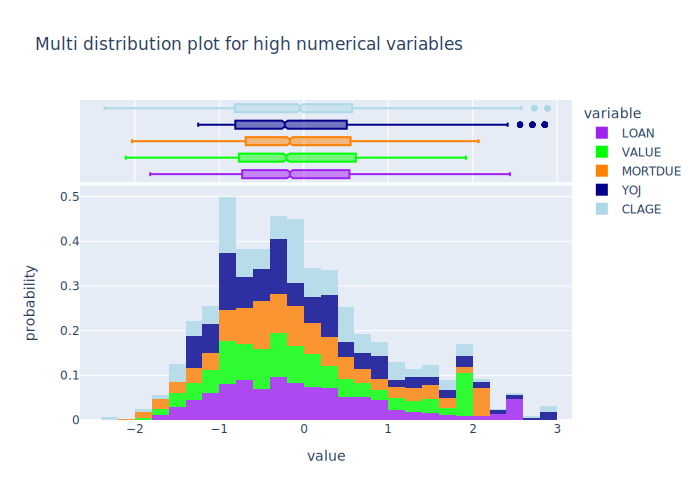

In [39]:
x_vars = ['LOAN', 'VALUE', 'MORTDUE', 'YOJ', 'CLAGE']

# normalize the variables because they're on different scales
loan_norm = (loan[x_vars] - loan[x_vars].mean()) / loan[x_vars].std()

px.histogram(loan_norm, x=x_vars,
             nbins=50, title='Multi distribution plot for high numerical variables',
             histnorm='probability', 
             opacity=0.8, marginal='box', 
             color_discrete_sequence=['#A020F0', '#00FF00', '#FF8000', '#00008B', '#ADD8E6'])

Let's find out the stats summary for these numerical variables to have a quick look at the numbers

In [40]:
def test_normality(data):
    normal_test_list = [
        ('LOAN', stats.normaltest(data['LOAN'])[1]),
        ('VALUE', stats.normaltest(data['VALUE'])[1]),
        ('MORTDUE', stats.normaltest(data['MORTDUE'])[1]),
        ('YOJ', stats.normaltest(data['YOJ'])[1]),
        ('CLAGE', stats.normaltest(data['CLAGE'])[1]),
        ('DEROG', stats.normaltest(data['DEROG'])[1]),
        ('DELINQ', stats.normaltest(data['DELINQ'])[1]),
        ('NINQ', stats.normaltest(data['NINQ'])[1]),
        ('CLNO', stats.normaltest(data['CLNO'])[1]),
        ('DEBTINC', stats.normaltest(data['DEBTINC'])[1])
    ]
    # loop for name of the variable and whether or not it's normal
    for var, pval in normal_test_list:
        if pval < 0.05:
            print(var, ": NOT normal")
        else:
            print(var, ": normal")
            
test_normality(loan)

LOAN : NOT normal
VALUE : NOT normal
MORTDUE : NOT normal
YOJ : NOT normal
CLAGE : NOT normal
DEROG : NOT normal
DELINQ : NOT normal
NINQ : NOT normal
CLNO : NOT normal
DEBTINC : NOT normal


#### Observations
- no numerical variables are normally distributed.

#### 2. How does the distribution of years at present job "YOJ" vary across the dataset?
**Observations** 
1. The average is about 9 years with a large standard deviation close to the average at 7 and a half years
2. The minimum is strage as it is in 0 years which does not make sense but it could be that it's less than a year of working at their current job
3. The most years working at current job tops out at 41 years

#### 3. How many unique categories are there in the REASON variable?

In [41]:
loan.REASON.nunique()

2

**Observations**
1. I find it strange that there weren't more than 2 categories, or an 'Other' category as surely there must be more than 2 reasons to take out a loan
2. JOB and REASON variables will be one-hot encoded later for the models

#### 4. What is the most common category in the JOB variable?

In [42]:
loan['JOB'].value_counts()

ProfExe    1252
Office      921
Mgr         746
Self        188
Sales       109
Name: JOB, dtype: int64

#### Observation
- Professional executive isn't very descriptive while sales probably means sales-person

#### Loan status vs. job fields

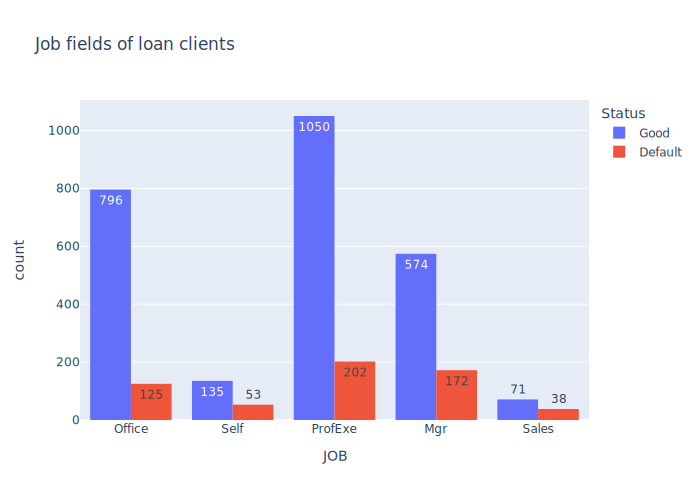

In [43]:
px.histogram(loan, x='JOB', title='Job fields of loan clients',
             color='Status', barmode='group',text_auto=True)

#### Observations
- In both good and default status, Prof ex make up the largest portion but Office jobs make up the 2nd largest portion in good loans unlike in defaulting where Managers up the 2nd largest
- Self-employed is the least common job of clients who take out a loan

In [44]:
np.round(loan['DEBTINC'].describe().T,2)

count    3216.00
mean       33.51
std         6.78
min        14.35
25%        29.03
50%        34.41
75%        38.56
max        53.80
Name: DEBTINC, dtype: float64

**Observations**
1. This data seems to be left skewed meaning as the ratio of debt to income increases, we find more and more people in that level with around 35 being the most common. 
2. The max value is more than 3x the standard deviation value at 53.8

#### 5. Is there a relationship between the REASON variable and the proportion of applicants who defaulted on their loan?

Let's answer that with a chi-squared hypothesis test: 

State the hypothesis:
* $H_0:$ There is no relationship between the two Reasons and loan status.  
* $H_1:$ There is a statistically significant relationship between between the reasons for taking out a loan and whethere or not the loan will be paid of

alpha = 0.05

In [45]:
from scipy.stats import chi2_contingency

reason_status_cont = pd.crosstab(loan['Status'], loan['REASON'])

status_reason = chi2_contingency(reason_status_cont)[1]

if status_reason < 0.05:
    print('Evidence to reject the null hypothesis, there is a relationship between the two variables')
else:
    print('Evidence is not sufficient to reject the null, there is no significant relationship')

Evidence is not sufficient to reject the null, there is no significant relationship


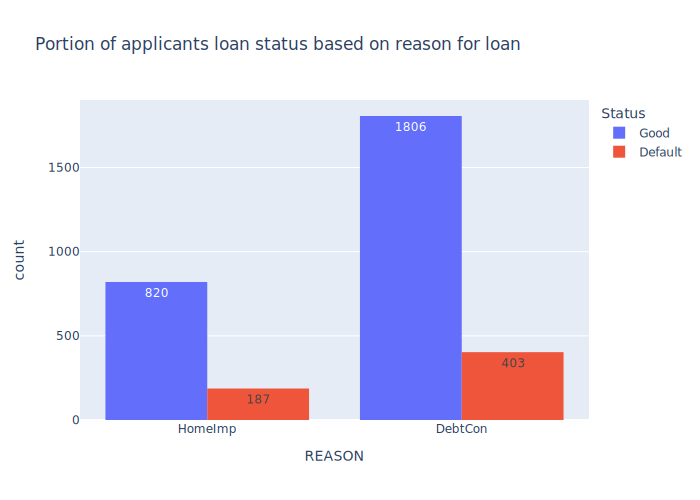

In [46]:
px.histogram(loan, x='REASON', 
             color='Status', 
             barmode='group', 
             text_auto=True, title='Portion of applicants loan status based on reason for loan')

**Observations**
1. This questions is tough to answer because we do not have the same number of clients who take a loan out for the same reasons 
2. For both people who took a loan for home improvement and defaulted(187) vs. those who took it out for debt consolidation(403)
2. An overwhelming people take out a loan for debt consolidation and paid it off. 

Let's see if the # of derogatory reports(which probably includes the delinquent payments) has any relationship 
with the status of loans

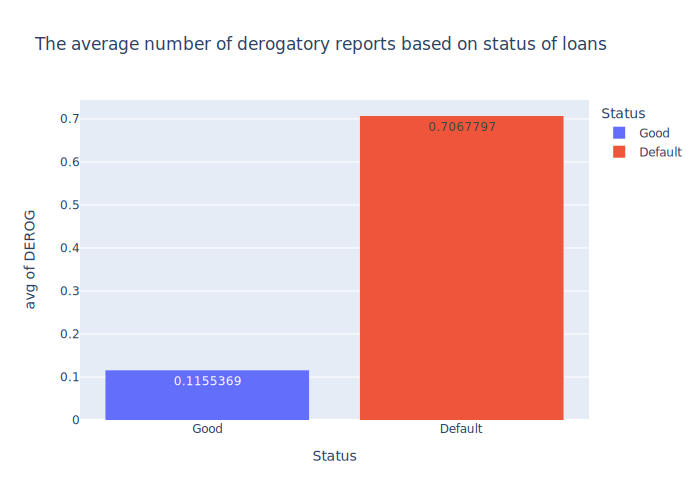

In [47]:
px.histogram(loan, x='Status', y='DEROG',
             color='Status', 
             histfunc='avg', 
             text_auto=True, title=
             'The average number of derogatory reports based on status of loans')

**Observations**
1. This is quite an overwhelming difference in the average of GL at 0.08 and DL at 0.7

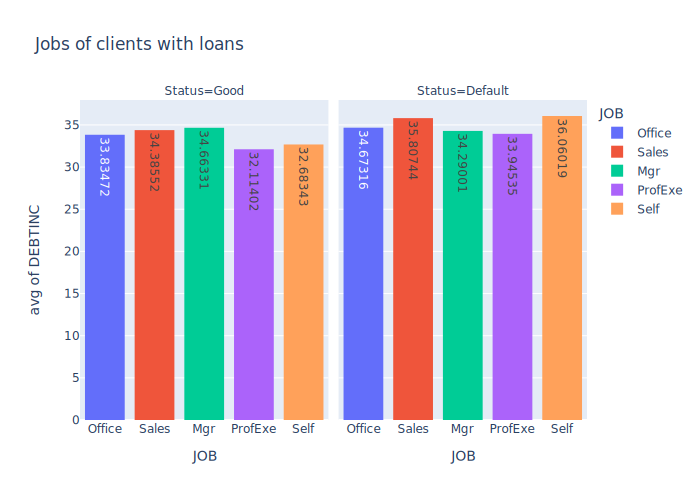

In [48]:
px.histogram(loan, title='Jobs of clients with loans', y='DEBTINC',
             x='JOB', histfunc='avg',color='JOB', facet_col="Status",
             text_auto=True)

**Observations**
1. There doesn't seem to be any outliers or stark difference between the jobs and their average Debt to income ratio for both default and good status clients. 

**Observation**
1. There isn't really a correlation for either variable
2. THe good status loans have a slight negative correlation between size of loan and years worked at current job
3. For defaulted clients, it's the opposite

#### Loan Amount vs. Debt to Income Ratio

- Using linear regression, we analyzed the relationship between the loan amount (LOAN) and the debt to income ratio (DEBTINC), considering loan status (BAD). The resulting R-squared value of 0.013 indicates a very weak linear relationship. This value signifies that only 1.3% of the variance in the debt-to-income ratio is predictable from the loan amount, suggesting that LOAN is not a strong predictor of DEBTINC. Interestingly, defaulted loans tend to have a higher debt-to-income ratio, pointing to other contributory factors to loan default.

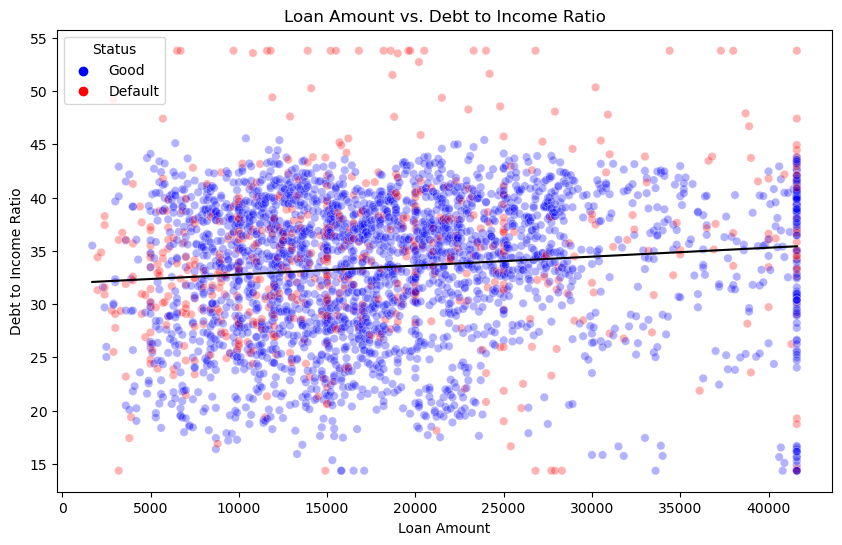

In [50]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=loan, x='LOAN', y='DEBTINC', hue='Status', alpha=0.3,
               palette={'Good':'blue','Default':'red'})

# Add the trend line
plt.plot(loan['LOAN'], loan['best_fit'], color='black')

# Set title and labels
plt.title('Loan Amount vs. Debt to Income Ratio')
plt.xlabel('Loan Amount')
plt.ylabel('Debt to Income Ratio')
plt.show()

In [59]:
X = sm.add_constant(loan['LOAN'])
y = loan['DEBTINC']
model = sm.OLS(y, X).fit()
loan['best_fit'] = model.predict(X)

print(f"The R^2 value is: {round(model.rsquared,3)}")

The R^2 value is: 0.013


#### Observations
- - there are loan defaults across the entire range of debt to income ratios so it seems defaulting is not strongly correlated with the debt to income ratio with the majority of loans, regardless of status clusters between 20% and 50%.
- The linear regression trend line is suggesting no significant correlation between loan amount and debt to income ratio. 

####  Loan amount based on default status
- is the amount significantly different? 

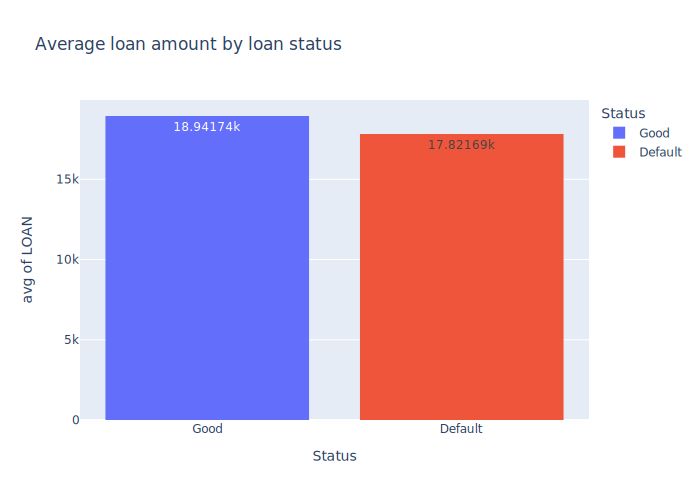

In [51]:
px.histogram(loan, histfunc='avg', title='Average loan amount by loan status', 
             x='Status', y='LOAN', color='Status', text_auto=True)

In [52]:
np.round((loan[loan['Status'] ==
               'Good']['LOAN'].mean()) - (loan[loan['Status'] == 'Default']['LOAN'].mean()),2)                                                                  

1120.04

**Observations**
1. Surprisingly, the average for defaulting loan amount is smaller than the good status loans.
2. only about a 1100 dollar difference between the averages

Let's answer with a Mann-Whitney U test since LOAN is not normally distributed: 

State the hypothesis:
* $H_0:$ The average approved loan is defaulting and good clients are statistically the same.   
* $H_1:$ There is a statistically significant difference bewteen the average of clients who default and good clients

alpha = 0.05

In [53]:
# Since LOAN is not normally distributed, we have to use the mann-whitney U test

default_loan = loan[loan['Status'] == 'Default']['LOAN']
good_loan = loan[loan['Status'] == 'Good']['LOAN']

stat, p = stats.mannwhitneyu(default_loan, good_loan) # Conducting the test 

if p < 0.05:
    print('Sufficient evidence to reject the null hypothesis')
else:
    print('Not enough evidence to reject the null hypothesis')

Sufficient evidence to reject the null hypothesis


**Observation**
1. SO even though it is only about 1.1k, it is a significant difference

####  Is there a correlation between the value of the property and the loan default rate?

Let's answer that with a similar test: 

State the hypothesis:
* $H_0:$ The average value of property between good and defaulting clients are statistically the same.   
* $H_1:$ There is a statistically significant difference bewteen the average property value of good and defaulting clients

alpha = 0.05

In [54]:
default_value = loan[loan['Status'] == 'Default']['VALUE']
good_value = loan[loan['Status'] == 'Good']['VALUE']

stat, p = stats.mannwhitneyu(default_value, good_value) 
if p < 0.05:
    print('Sufficient evidence to reject the null hypothesis')
else:
    print('Not enough evidence to reject the null hypothesis')

Sufficient evidence to reject the null hypothesis


In [55]:
np.round(good_value.mean() - default_value.mean())

8900.0

**Observations**
1. Similar to the relationship between Loan amount and default rate, there isn't a stark visual difference in the average property value of good and defaulting clients but statistically there is a difference. 
2. The average value of property of good clients is 7.9k higher than defaulting clients

#### 8. Loan status vs. mortgage due 
- is there a significant difference between mortgage amount of good and bad loans? 

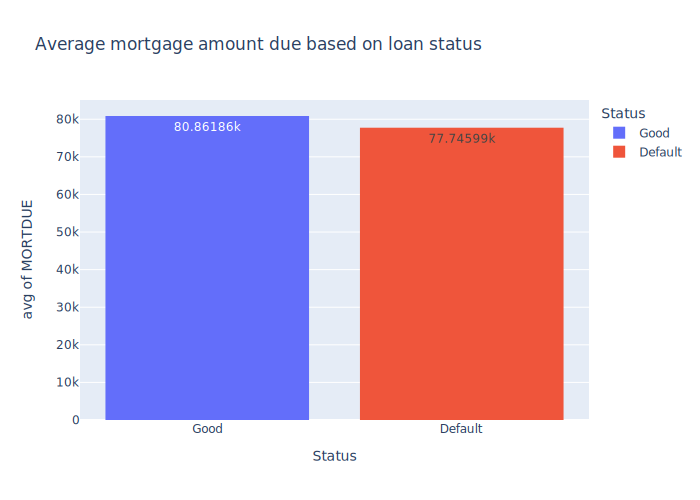

In [56]:
px.histogram(loan, x='Status', title='Average mortgage amount due based on loan status', 
             color='Status', text_auto=True, y='MORTDUE', histfunc='avg')

In [ ]:
np.round(good_mort.mean() - default_mort.mean())

**Observations**
1. Based on a visual, there isn't a big difference at all  but this 3.4K difference is statistically significant so we can reject the null hypothesis
2. Just like property value of house and loan amount, mortgage due is also higher for good status loans.

Let's answer that with another mann-whitney test since MORTDUE is not normally distributed either: 

State the hypothesis:
* $H_0:$ The average mortgage left on the property between good and defaulting clients are statistically the same. 
* $H_1:$ There is a statistically significant difference bewteen the average mortgage left bewteen good and defaulting clients

alpha = 0.05

In [57]:
default_mort = loan[loan['Status'] == 'Default']['MORTDUE']
good_mort = loan[loan['Status'] == 'Good']['MORTDUE']

stat, p = stats.mannwhitneyu(default_mort, good_mort) 

if p < 0.05:
    print('Sufficient evidence to reject the null hypothesis')
else:
    print('Not enough evidence to reject the null hypothesis')

Sufficient evidence to reject the null hypothesis


# Conclusion

- Financial metrics such as loan amount, property value, and mortgage due show are not as significantly correlated to loan status and a higher proportion of defaults is observed in debt consolidation loans compared to home improvement loans.
- Job categories and years at the current job do not show a significant distinction between defaulting and non-defaulting clients.
- credit-related factors such as including debt-to-income ratio and number of derogatory reports provide greater insights into the financial health of clients which ultimate provides insight into defaulting and good loan status.

## Executive Summary
Global Bank (GB) can benefit from placing a greater importance on the reasons for the loan, and the financial standing of clients
The bank should consider these factors in their loan approval process to minimize defaults and maximize successful loan repayments.
## Recommendations for Future Analysis
- A more diverse set of categories for job types, as well as loan reasons and a more detailed report of income could provide further insights.
- Additional data points, such as credit score and historical financial behavior, could enhance the understanding of default risks.